# IASI Data Experiment

In [6]:
import sys
sys.path.append('/home/emmanuel/projects/2019_egp/src')
from data.iasi import IASIOrbits, create_dataarray
from experiments.experiment_iasi import GPModels
from models.gp_models import SparseGP
import GPy
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.externals import joblib

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experimental Parameters

In [35]:
n_components = 50
train_size = 5000
n_train_orbits = 'all'
n_test_orbits = 'all'
random_state = 123
chunksize = 4000
rng = np.random.RandomState(random_state)

orbits = [
    '20131001120859', 
    '20131001102955',
    '20131001015955',
    '20131001202954',
    '20131001185058',
    '20131001084755',
    '20131001152954',
    '20131001170858',
    '20131001221154', 
    '20131001135058', 
    '20131001034155', 
    '20131001070555', 
    '20131001052355']
print(len(orbits))
day = orbits[0][:8]

13


In [36]:
iasi_data = IASIOrbits(
    n_components = n_components,
    train_size=train_size,
    input_noise_level=None,
    noise_coefficient=1.0,
    n_train_orbits=n_train_orbits,
    n_test_orbits=n_test_orbits,
)

# Get Training Data
training_data = iasi_data.get_training_data()

Gathering data...
Orbit: 20131001120859
Orbit: 20131001102955
Orbit: 20131001015955
Orbit: 20131001202954
Orbit: 20131001185058
Orbit: 20131001084755
Orbit: 20131001152954
Orbit: 20131001170858
Orbit: 20131001221154
Orbit: 20131001135058
Orbit: 20131001034155
Orbit: 20131001070555
Orbit: 20131001052355
Getting error...
Finding PCA Transformation...
Transformating data...
Splitting into training and testing...


 /home/emmanuel/.conda/envs/2019_egp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:From version 0.21, test_size will always complement train_size unless both are specified.


### Training Region

In [37]:
train_xarray = create_dataarray(
    training_data['y'], 
    training_data['lat'], 
    training_data['lon'], 
    day)
train_xarray.name = 'Temperature'

In [38]:
train_xarray.min(), train_xarray.max()

(<xarray.DataArray 'Temperature' ()>
 array(218.57103), <xarray.DataArray 'Temperature' ()>
 array(308.858643))

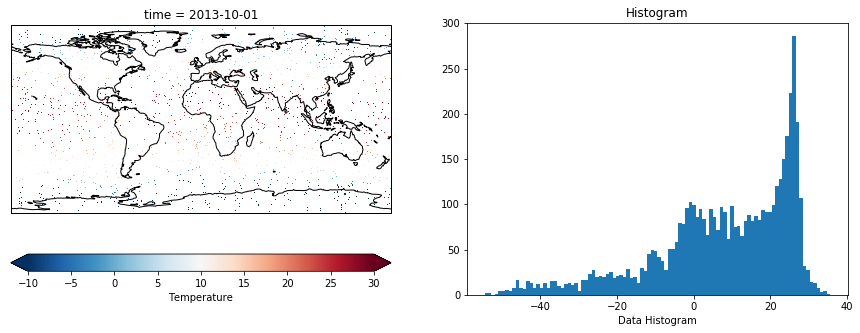

In [39]:
# Labeled Data
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121,  projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122)

plot_data = train_xarray.isel(time=0) - 273.15

plot_data.plot.imshow(ax=ax1, transform=ccrs.PlateCarree(), 
                      cmap='RdBu_r', alpha=1.0, vmin=-10, vmax=30, 
                      cbar_kwargs={'orientation': 'horizontal',
                                   'label': 'Temperature'})
ax1.coastlines()
plot_data.plot.hist(ax=ax2, bins=100)
ax2.set_xlabel('Data Histogram')
# fig.savefig(fig_save_loc + 't1_bias.png')
plt.show()

### Save Training Data

In [ ]:
save_path = '/home/emmanuel/projects/2019_egp/data/processed/'

# DATA
train_xarray.to_netcdf(f"{save_path}training_egp_v1.nc")

### Model Parameters and Training

In [40]:
# Model Parameters
init_params = True
n_inducing = 1000
x_variance = iasi_data.x_cov
n_restarts = 1

In [41]:
# Initialize Modeler
clf = GPModels(
    init_params = init_params,
    x_variance=x_variance,
    n_inducing=n_inducing,
    n_restarts=n_restarts,
)

# Fit Models
clf.train_models(
    training_data['X'],
    training_data['y']
);

Training Standard GP...
Training Error GP...


#### Save Models

In [43]:
save_path = '/home/emmanuel/projects/2019_egp/data/processed/'

# MODELS
joblib.dump(clf, f"{save_path}models_v1.pckl");

In [42]:
clf.models['error'].kernel_

316**2 * RBF(length_scale=594) + WhiteKernel(noise_level=9.5)

### Testing

In [32]:
iasi_data.n_test_orbits = 13

In [44]:
datasets = xr.Dataset()
n_test = list()
for xtest, labels, lon, lat, orbit in iasi_data.get_testing_data():
    n_test.append(xtest.shape)
    temp_dataset = xr.Dataset()
    # Save Labels Dataarray
    temp_dataset['Temperature'] = create_dataarray(labels, lat, lon, orbit)
    
    
    for imodel, ypred, ystd in clf.test_models(xtest, noise_less=True):
        
        # Create Predictions array
        temp_dataset[f"{imodel}_pred"] = create_dataarray(ypred, lat, lon, orbit)
        
        # Create Standard Deviations array
        temp_dataset[f"{imodel}_std"] = create_dataarray(ystd, lat, lon, orbit)
        
    datasets = datasets.merge(temp_dataset)
    del temp_dataset
n_test = np.array(n_test)

Loading data from orbit 20131001120859
Loading data from orbit 20131001102955
Loading data from orbit 20131001015955
Loading data from orbit 20131001202954
Loading data from orbit 20131001185058
Loading data from orbit 20131001084755
Loading data from orbit 20131001152954
Loading data from orbit 20131001170858
Loading data from orbit 20131001221154
Loading data from orbit 20131001135058
Loading data from orbit 20131001034155
Loading data from orbit 20131001070555
Loading data from orbit 20131001052355


## Save Results

In [45]:
save_path = '/home/emmanuel/projects/2019_egp/data/processed/'

# DATA
datasets.to_netcdf(f"{save_path}results_egp_v1.nc")